# ECE9143 HPML Lab3
Yuanzhe Liu yl7897@nyu.edu

## Problem 1 - Weight Initialization, Dead Neurons, Leaky ReLU 20 points
**Read the two blogs, one by Andre Pernunicic and other by Daniel Godoy on weight initialization. You will reuse the code at GitHub repo linked in the blog for explaining vanishing and exploding gradients. You can use the same 5 layers neural network model as in the repo and the same dataset.**
1. **Explain vanishing gradients phenomenon using standard normalization with different values of standard deviation and tanh and sigmoid activation functions. Then show how Xavier (aka Glorot normal) initialization of weights helps in dealing with this problem. Next use ReLU activation and show that instead of Xavier initialization, He initialization works better for ReLU activation. You can plot activations at each of the 5 layers to answer this question. (8)**
   
    Vanishing gradients phenomenon happens when we perform back propagation, the gradients of the first fewer layer is smaller comparing to later layers, making earlier layers harder to learn the features. Xavier/Glorot normal initialize weights followed by zero-mean Gaussian distribution with std sqrt(2/(rin+rout)) where rin and rout are number of inputs and output weights for the neuron.


### Utils.py

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras import backend as K

from matplotlib import pyplot as plt
from matplotlib import rcParamsDefault

In [2]:
def grid_axes_it(n_plots, n_cols=3, enumerate=False, fig=None):
    """
    Iterate through Axes objects on a grid with n_cols columns and as many
    rows as needed to accommodate n_plots many plots.

    Args:
        n_plots: Number of plots to plot onto figure.
        n_cols: Number of columns to divide the figure into.
        fig: Optional figure reference.

    Yields:
        n_plots many Axes objects on a grid.
    """
    n_rows = n_plots / n_cols + int(n_plots % n_cols > 0)

    if not fig:
        default_figsize = rcParamsDefault['figure.figsize']
        fig = plt.figure(figsize=(
            default_figsize[0] * n_cols,
            default_figsize[1] * n_rows
        ))

    for i in range(1, n_plots + 1):
        ax = plt.subplot(n_rows, n_cols, i)
        yield ax

In [3]:
def create_mlp_model(
    n_hidden_layers,
    dim_layer,
    input_shape,
    n_classes,
    kernel_initializer,
    bias_initializer,
    activation,
):
    """Create Multi-Layer Perceptron with given parameters."""
    model = Sequential()
    model.add(Dense(dim_layer, input_shape=input_shape, kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    for i in range(n_hidden_layers):
        model.add(Dense(dim_layer, activation=activation, kernel_initializer=kernel_initializer,
                        bias_initializer=bias_initializer))
    model.add(Dense(n_classes, activation='softmax', kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    return model

In [4]:
def create_cnn_model(input_shape, num_classes, kernel_initializer='glorot_uniform',
                     bias_initializer='zeros'):
    """Create CNN model similar to
       https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py."""
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer))
    model.add(Conv2D(64, (3, 3), activation='relu',
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu',
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax',
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    return model

In [5]:
def compile_model(model):
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'])
    return model

In [6]:
def get_init_id(init):
    """
    Returns string ID summarizing initialization scheme and its parameters.

    Args:
        init: Instance of some initializer from keras.initializers.
    """
    try:
        init_name = str(init).split('.')[2].split(' ')[0]
    except:
        init_name = str(init).split(' ')[0].replace('.', '_')

    param_list = []
    config = init.get_config()
    for k, v in config.items():
        if k == 'seed':
            continue
        param_list.append('{k}-{v}'.format(k=k, v=v))
    init_params = '__'.join(param_list)

    return '|'.join([init_name, init_params])

In [7]:
def get_activations(model, x, mode=0.0):
    """Extract activations with given model and input vector x."""
    outputs = [layer.output for layer in model.layers]
    activations = K.function([model.input], outputs)
    output_elts = activations([x, mode])
    return output_elts

In [8]:
class LossHistory(keras.callbacks.Callback):
    """A custom keras callback for recording losses during network training."""

    def on_train_begin(self, logs={}):
        self.losses = []
        self.epoch_losses = []
        self.epoch_val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

    def on_epoch_end(self, epoch, logs={}):
        self.epoch_losses.append(logs.get('loss'))
        self.epoch_val_losses.append(logs.get('val_loss'))

### Plot Activation Layers

In [9]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras import initializers
from keras.datasets import mnist

In [10]:
seed = 10

# Number of points to plot
n_train = 10
n_test = 100
n_classes = 10

# Network params
n_hidden_layers = 5
dim_layer = 100
batch_size = n_train
epochs = 1

# Load and prepare MNIST dataset.
n_train = 60000
n_test = 10000

(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = len(np.unique(y_test))
data_dim = 28 * 28

x_train = x_train.reshape(60000, 784).astype('float32')[:n_train]
x_test = x_test.reshape(10000, 784).astype('float32')[:n_train]
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [11]:
# Run the data through a few MLP models and save the activations from
# each layer into a Pandas DataFrame.
rows = []
sigmas = [0.10, 0.14, 0.28]
for stddev in sigmas:
    init = initializers.RandomNormal(mean=0.0, stddev=stddev, seed=seed)
    # init = initializers.GlorotNormal()
    # init = initializers.HeNormal()
    # activation = 'relu'
    activation = 'tanh'
    # activation = 'sigmoid'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])
    
df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

<ipython-input-2-5773ad2b15ff>:24: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)
<ipython-input-2-5773ad2b15ff>:24: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)
<ipython-input-2-5773ad2b15ff>:24: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)


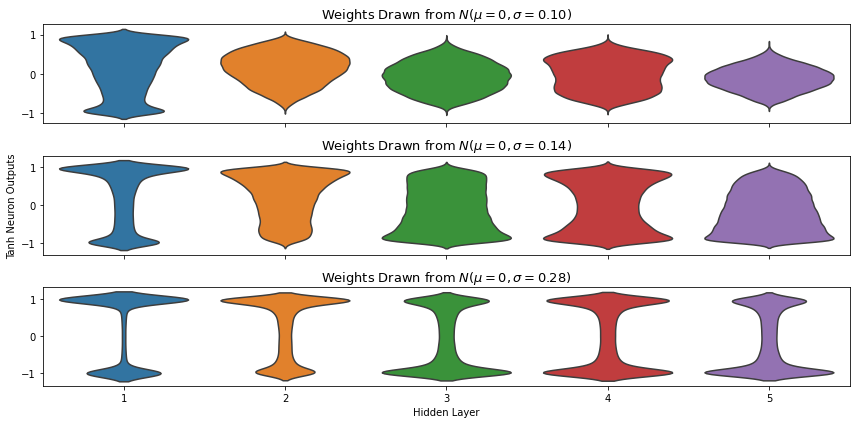

In [12]:
# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("Tanh Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

In [13]:
# Run the data through a few MLP models and save the activations from
# each layer into a Pandas DataFrame.
rows = []
sigmas = [0.10, 0.14, 0.28]
for stddev in sigmas:
    init = initializers.RandomNormal(mean=0.0, stddev=stddev, seed=seed)
    # init = initializers.GlorotNormal()
    # init = initializers.HeNormal()
    # activation = 'relu'
    # activation = 'tanh'
    activation = 'sigmoid'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])
    
df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

<ipython-input-2-5773ad2b15ff>:24: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)
<ipython-input-2-5773ad2b15ff>:24: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)
<ipython-input-2-5773ad2b15ff>:24: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)


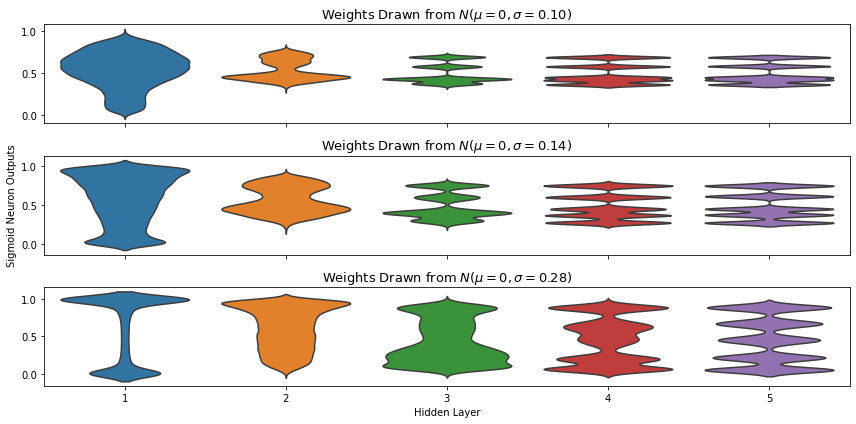

In [14]:
# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("Sigmoid Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

<ipython-input-2-5773ad2b15ff>:24: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)


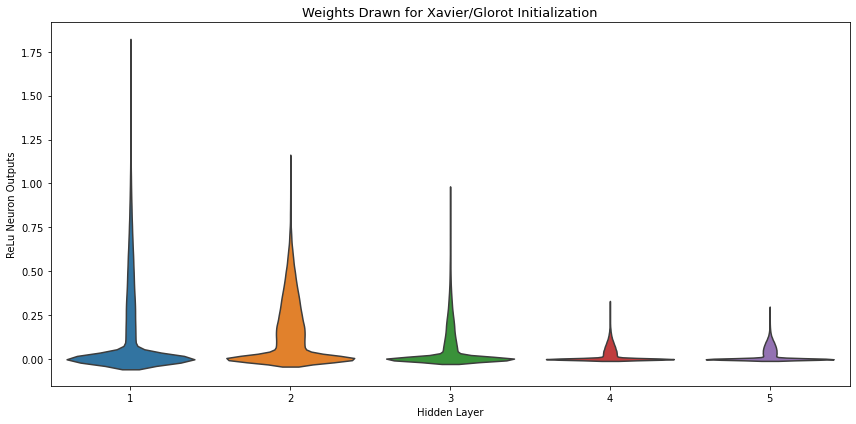

In [15]:
# Run the data through a few MLP models and save the activations from
# each layer into a Pandas DataFrame.
rows = []
sigmas = [0]
for stddev in sigmas:
    # init = initializers.RandomNormal(mean=0.0, stddev=stddev, seed=seed)
    init = initializers.GlorotNormal(seed=seed)
    # init = initializers.HeNormal()
    activation = 'relu'
    # activation = 'tanh'
    # activation = 'sigmoid'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])
    
df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn for Xavier/Glorot Initialization', fontsize=13)

    ax.set_ylabel("ReLu Neuron Outputs")
    ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

<ipython-input-2-5773ad2b15ff>:24: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)


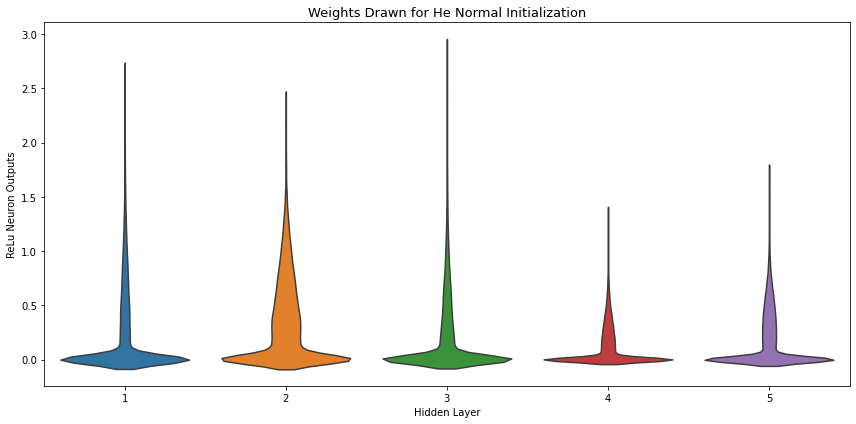

In [16]:
# Run the data through a few MLP models and save the activations from
# each layer into a Pandas DataFrame.
rows = []
sigmas = [0]
for stddev in sigmas:
    # init = initializers.RandomNormal(mean=0.0, stddev=stddev, seed=seed)
    # init = initializers.GlorotNormal()
    init = initializers.HeNormal(seed=seed)
    activation = 'relu'
    # activation = 'tanh'
    # activation = 'sigmoid'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])
    
df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn for He Normal Initialization', fontsize=13)

    ax.set_ylabel("ReLu Neuron Outputs")
    ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

2. The dying ReLU is a kind of vanishing gradient, which refers to a problem when ReLU neurons become inactive and only output 0 for any input. In the worst case of dying ReLU, ReLU neurons at a certain layer are all dead, i.e., the entire network dies and is referred to as the dying ReLU neural networks in Lu et al (reference below). A dying ReLU neural network collapses to a constant function. Show this phenomenon using any one of the three 1-dimensional functions on page 13 of Lu et al. Use a 10-layer ReLU network with width 2 (hidden units per layer). Use minibatch of 64 and draw training data uniformly from [−√7,√7].

    Perform 1000 independent training simulations each with 3,000 training points. Out of these 1000 simulations, what fraction resulted in neural network collapse. Is your answer close to over 90% as was reported in Lu et al. ? (8)

In [17]:
from operator import mod
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import math
import os

In [18]:
'''Some helper functions for PyTorch, including:
    - get_mean_and_std: calculate the mean and std value of dataset.
    - msr_init: net parameter initialization.
    - progress_bar: progress bar mimic xlua.progress.
'''
import os
import sys
import time
import math
import shutil
import torch.nn as nn
import torch.nn.init as init


def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight, mode='fan_out')
            if m.bias:
                init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant(m.weight, 1)
            init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal(m.weight, std=1e-3)
            if m.bias:
                init.constant(m.bias, 0)


_, term_width = shutil.get_terminal_size()
term_width = int(term_width)

TOTAL_BAR_LENGTH = 65.
last_time = time.time()
begin_time = last_time
def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current+1, total))

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()

def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Linear_BasicBlock(nn.Module):
    # Basic Linear layer with batch norm and relu.
    def __init__(self, inputSize, outputSize):
        super(Linear_BasicBlock, self).__init__()
        self.linear = nn.Linear(inputSize, outputSize)
        # self.bn = nn.BatchNorm2d(outputSize)
    
    def forward(self, x):
        out = F.relu(self.linear(x))
        return out

In [20]:
from operator import mod
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

import numpy as np
import math
import os

In [21]:
x = np.linspace(start=-math.sqrt(7), stop=math.sqrt(7), num=3000, endpoint=True)
x_train = np.array(x, dtype=np.float32).reshape(-1, 1)

y = abs(x)
# y = [a * math.sin(5*a) for a in x]
# y = [(a if a > 0 else 0) + 0.2 * math.sin(5 * a) for a in x]
y_train = np.array(y, dtype=np.float32).reshape(-1, 1)

my_dataset = TensorDataset(Tensor(x_train), Tensor(y_train))
my_dataloader = DataLoader(my_dataset, batch_size=64, shuffle=True, num_workers=2)

In [22]:
inputDim = 1        # takes variable 'x' 
outputDim = 1       # takes variable 'y'
learningRate = 0.01 
epochs = 10
# model = P1()

##### For GPU #######
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = model.to(device)


In [ ]:
class P1(nn.Module):
    def __init__(self):
        super(P1, self).__init__()
        self.inputlayer = Linear_BasicBlock(1, 2)
        self.hiddenlayers = self.make_layer_(10)
        self.outputlayer = Linear_BasicBlock(2, 1)

    def make_layer_(self, numlayers):
        layers = []
        for _ in range(numlayers):
            layers.append(Linear_BasicBlock(2,2))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.inputlayer(x)
        out = self.hiddenlayers(out)
        out = self.outputlayer(out)
        return out

In [23]:
# from torchsummary import summary
# summary(model, (1, 1, 1))

In [24]:
def train(model, criterion, optimizer):
    # print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(my_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # progress_bar(batch_idx, len(my_dataloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        #             % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        # for param in model.parameters():
        #     print(param)

In [25]:
def test(model, criterion):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(my_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # progress_bar(batch_idx, len(my_dataloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            #              % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

In [27]:
misscount = 0
for simulation in range(1000):
    
    model_p1_2 = P1() # torch module class. Here P1() or P1_leaky()
    model_p1_2 = model_p1_2.to(device)

    criterion = torch.nn.MSELoss() 
    optimizer = torch.optim.SGD(model_p1_2.parameters(), lr=learningRate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

    # for epoch in range(0, 10):
    train(model_p1_2, criterion, optimizer)
    test(model_p1_2, criterion)
    scheduler.step()
    
    model_p1_2.eval()
    with torch.no_grad():
        yhat = model_p1_2(Tensor(x_train).to(device))
    yhat = np.array(yhat.cpu().tolist()).flatten()
    if sum(yhat) == 0:
        misscount += 1
        
    if simulation % 10 == 0:
        print('Simulation: ', simulation, ' Misscount: ', misscount) 
    del model_p1_2
print('Collapsed rate: %.2f' % (misscount/1000))


Simulation:  0  Misscount:  0
Simulation:  1  Misscount:  1
Simulation:  2  Misscount:  1
Simulation:  3  Misscount:  2
Simulation:  4  Misscount:  3
Simulation:  5  Misscount:  3
Simulation:  6  Misscount:  4
Simulation:  7  Misscount:  5
Simulation:  8  Misscount:  5
Simulation:  9  Misscount:  5
Simulation:  10  Misscount:  6
Simulation:  11  Misscount:  6
Simulation:  12  Misscount:  6
Simulation:  13  Misscount:  6
Simulation:  14  Misscount:  6
Simulation:  15  Misscount:  7
Simulation:  16  Misscount:  8
Simulation:  17  Misscount:  8
Simulation:  18  Misscount:  8
Simulation:  19  Misscount:  9
Simulation:  20  Misscount:  10
Simulation:  21  Misscount:  10
Simulation:  22  Misscount:  11
Simulation:  23  Misscount:  11
Simulation:  24  Misscount:  11
Simulation:  25  Misscount:  11
Simulation:  26  Misscount:  12
Simulation:  27  Misscount:  12
Simulation:  28  Misscount:  13
Simulation:  29  Misscount:  14
Simulation:  30  Misscount:  14
Simulation:  31  Misscount:  15
Simula

In [28]:
# torch.save(model.state_dict(), 'q1_1000.pth')

In [29]:
# plt.plot(x, y, '-b', label='y')
# plt.plot(x, yhat, '-r', label='yhat')
# plt.legend()
# plt.show()

In [63]:
import torch
import torch.nn as nn

class Linear_BasicBlock2(nn.Module):
    # Basic Linear layer with batch norm and relu.
    def __init__(self, inputSize, outputSize):
        super(Linear_BasicBlock2, self).__init__()
        self.linear = nn.Linear(inputSize, outputSize)
    
    def forward(self, x):
        leakyrelu = nn.LeakyReLU(0.01)
        out = leakyrelu(self.linear(x))
        return out

In [64]:
class P1_leaky(nn.Module):
    def __init__(self):
        super(P1_leaky, self).__init__()
        self.inputlayer = Linear_BasicBlock2(1, 2)
        self.hiddenlayers = self.make_layer_(10)
        self.outputlayer = Linear_BasicBlock2(2, 1)

    def make_layer_(self, numlayers):
        layers = []
        for _ in range(numlayers):
            layers.append(Linear_BasicBlock2(2,2))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.inputlayer(x)
        out = self.hiddenlayers(out)
        out = self.outputlayer(out)
        return out

In [33]:
misscount = 0
for simulation in range(1000):
    
    model_p1_3 = P1_leaky() # torch module class. Here P1() or P1_leaky()
    model_p1_3 = model_p1_3.to(device)

    criterion = torch.nn.MSELoss() 
    optimizer = torch.optim.SGD(model_p1_3.parameters(), lr=learningRate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

    # for epoch in range(0, 10):
    train(model_p1_3, criterion, optimizer)
    test(model_p1_3, criterion)
    scheduler.step()

    model_p1_3.eval()
    with torch.no_grad():
        yhat = model_p1_3(Tensor(x_train).to(device))
    yhat = np.array(yhat.cpu().tolist()).flatten()
    if sum(yhat) == 0:
        misscount += 1
        
    if simulation % 10 == 0:
        print('Simulation: ', simulation, ' Misscount: ', misscount) 
    del model_p1_3
print('Collapsed rate: %.2f' % (misscount/1000))

Simulation:  0  Misscount:  0
Simulation:  1  Misscount:  0
Simulation:  2  Misscount:  0
Simulation:  3  Misscount:  0
Simulation:  4  Misscount:  0
Simulation:  5  Misscount:  0
Simulation:  6  Misscount:  0
Simulation:  7  Misscount:  0
Simulation:  8  Misscount:  0
Simulation:  9  Misscount:  0
Simulation:  10  Misscount:  0
Simulation:  11  Misscount:  0
Simulation:  12  Misscount:  0
Simulation:  13  Misscount:  0
Simulation:  14  Misscount:  0
Simulation:  15  Misscount:  0
Simulation:  16  Misscount:  0
Simulation:  17  Misscount:  0
Simulation:  18  Misscount:  0
Simulation:  19  Misscount:  0
Simulation:  20  Misscount:  0
Simulation:  21  Misscount:  0
Simulation:  22  Misscount:  0
Simulation:  23  Misscount:  0
Simulation:  24  Misscount:  0
Simulation:  25  Misscount:  0
Simulation:  26  Misscount:  0
Simulation:  27  Misscount:  0
Simulation:  28  Misscount:  0
Simulation:  29  Misscount:  0
Simulation:  30  Misscount:  0
Simulation:  31  Misscount:  0
Simulation:  32  M

## Problem 2 - Batch Normalization, Dropout, MNIST 20 points

Batch normalization and Dropout are used as effective regularization techniques. However, it is not clear
which one should be preferred and whether their benefits add up when used in conjunction. In this problem,
we will compare batch normalization, dropout, and their conjunction using MNIST and LeNet-5 (see e.g.,
http://yann.lecun.com/exdb/lenet/). LeNet-5 is one of the earliest convolutional neural networks developed
for image classification and its implementation in all major frameworks is available.

1. Explain the terms co-adaptation and internal covariance-shift. Use examples if needed. You may need
to refer to two papers mentioned below to answer this question. (4)

    Internal covariance-shift describe the phenomenon that the distribution of each layer's input changes during training along with the changes of parameters of the previous layers. This phenomenon slows down the training by requiring low learning rate and more attention in weight initialization.

    Co-adaptation means output of some neurons hightly depends on several other neurons. Co-adaptation is one of the most prominent reasons causing overfitting which the network learns too much information including noises which we don't want.

2. Batch normalization is traditionally used in hidden layers, for the input layer standard normalization
is used. In standard normalization, the mean and standard deviation are calculated using the entire
training dataset whereas in batch normalization these statistics are calculated for each mini-batch.
Train LeNet-5 with standard normalization of input and batch normalization for hidden layers. What
are the learned batch norm parameters for each layer? (4)

In [26]:
import numpy as np
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [27]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

In [28]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [29]:
def p2_train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [30]:
def p2_validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [31]:
def p2_training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = p2_train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = p2_validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)


In [32]:
# define transforms
# transforms.ToTensor() automatically scales the images to [0,1] range
transforms_p2_2 = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.1307,), (0.3081,))])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transforms_p2_2,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transforms_p2_2)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

In [33]:
class LeNet5_p2_2(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5_p2_2, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.BatchNorm2d(6), 
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.BatchNorm2d(16), 
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.BatchNorm2d(120), 
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.BatchNorm1d(84),
            nn.Linear(in_features=84, out_features=n_classes),
        )
        # self.fc1 = nn.Linear(in_features=120, out_features=84)
        # self.bn4 = nn.BatchNorm1d(84)
        # self.fc2 = nn.Linear(in_features=84, out_features=n_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        # x = self.fc1(x)
        # x = self.bn4(F.tanh(x))
        # logits = self.fc2(x)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [73]:

torch.manual_seed(RANDOM_SEED)

model_p2_2 = LeNet5_p2_2(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model_p2_2.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [74]:
from torchsummary import summary
summary(model_p2_2, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              Tanh-2            [-1, 6, 28, 28]               0
       BatchNorm2d-3            [-1, 6, 28, 28]              12
         AvgPool2d-4            [-1, 6, 14, 14]               0
            Conv2d-5           [-1, 16, 10, 10]           2,416
              Tanh-6           [-1, 16, 10, 10]               0
       BatchNorm2d-7           [-1, 16, 10, 10]              32
         AvgPool2d-8             [-1, 16, 5, 5]               0
            Conv2d-9            [-1, 120, 1, 1]          48,120
             Tanh-10            [-1, 120, 1, 1]               0
      BatchNorm2d-11            [-1, 120, 1, 1]             240
           Linear-12                   [-1, 84]          10,164
             Tanh-13                   [-1, 84]               0
      BatchNorm1d-14                   

13:10:19 --- Epoch: 0	Train loss: 0.1464	Valid loss: 0.0482	Train accuracy: 98.47	Valid accuracy: 98.44
13:10:56 --- Epoch: 1	Train loss: 0.0614	Valid loss: 0.0494	Train accuracy: 98.69	Valid accuracy: 98.35
13:11:33 --- Epoch: 2	Train loss: 0.0482	Valid loss: 0.0356	Train accuracy: 99.19	Valid accuracy: 98.76
13:12:14 --- Epoch: 3	Train loss: 0.0397	Valid loss: 0.0358	Train accuracy: 99.38	Valid accuracy: 98.74
13:12:52 --- Epoch: 4	Train loss: 0.0345	Valid loss: 0.0319	Train accuracy: 99.40	Valid accuracy: 98.99
13:13:30 --- Epoch: 5	Train loss: 0.0309	Valid loss: 0.0410	Train accuracy: 99.30	Valid accuracy: 98.73
13:14:05 --- Epoch: 6	Train loss: 0.0269	Valid loss: 0.0350	Train accuracy: 99.50	Valid accuracy: 98.75
13:14:41 --- Epoch: 7	Train loss: 0.0239	Valid loss: 0.0323	Train accuracy: 99.62	Valid accuracy: 99.01
13:15:18 --- Epoch: 8	Train loss: 0.0231	Valid loss: 0.0332	Train accuracy: 99.61	Valid accuracy: 98.84
13:15:57 --- Epoch: 9	Train loss: 0.0201	Valid loss: 0.0395	Trai

<ipython-input-36-a0bb8c0dfef0>:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


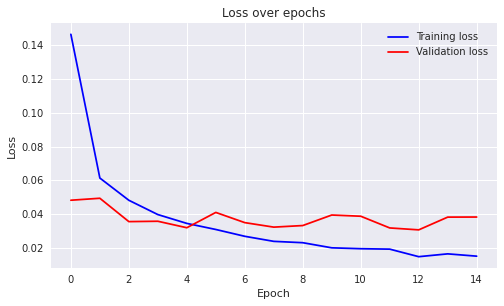

In [44]:
model_p2_2, optimizer, _ = p2_training_loop(model_p2_2, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

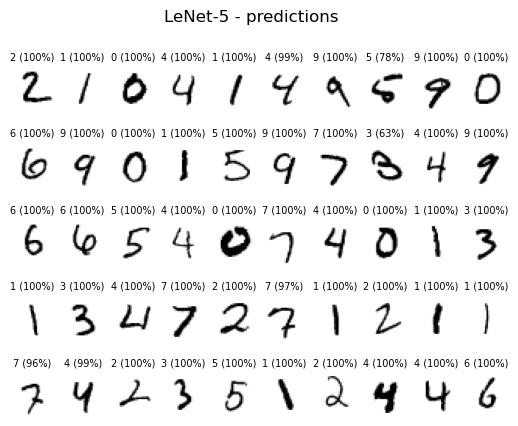

In [45]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.data[index], cmap='gray_r')
    
    with torch.no_grad():
        model_p2_2.eval()
        _, probs = model_p2_2(valid_dataset[index][0].unsqueeze(0).to(DEVICE))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - predictions');

In [46]:
for name, param in model_p2_2.named_parameters():
    # if param.requires_grad:
    if name == 'feature_extractor.2.weight':
        param_p2_2_bn1_w = param.data.to('cpu')
        print('Batch Norm 1 weight: ', param_p2_2_bn1_w.tolist())
    if name == 'feature_extractor.2.bias':
        param_p2_2_bn1_b = param.data.to('cpu')
        print('Batch Norm 1 bias: ', param_p2_2_bn1_b.tolist())
    if name == 'feature_extractor.6.weight':
        param_p2_2_bn2_w = param.data.to('cpu')
        print('Batch Norm 2 weight: ', param_p2_2_bn2_w.tolist())
    if name == 'feature_extractor.6.bias':
        param_p2_2_bn2_b = param.data.to('cpu')
        print('Batch Norm 2 bias: ', param_p2_2_bn2_b.tolist())
    if name == 'feature_extractor.10.weight':
        param_p2_2_bn3_w = param.data.to('cpu')
        print('Batch Norm 3 weight: ', param_p2_2_bn3_w.tolist())
    if name == 'feature_extractor.10.bias':
        param_p2_2_bn3_b = param.data.to('cpu')
        print('Batch Norm 3 bias: ', param_p2_2_bn3_b.tolist())
    if name == 'classifier.2.weight':
        param_p2_2_bn4_w = param.data.to('cpu')
        print('Batch Norm 3 weight: ', param_p2_2_bn4_w.tolist())
    if name == 'classifier.2.bias':
        param_p2_2_bn4_b = param.data.to('cpu')
        print('Batch Norm 3 bias: ', param_p2_2_bn4_b.tolist())
    # print(name, param.data)

Batch Norm 1 weight:  [0.8628733158111572, 1.0342401266098022, 0.859861433506012, 1.1124367713928223, 1.002983570098877, 1.3888342380523682]
Batch Norm 1 bias:  [0.4106857180595398, 0.28377339243888855, -0.017726408317685127, 0.34334489703178406, -0.28388842940330505, -0.2053515762090683]
Batch Norm 2 weight:  [0.8672081232070923, 0.8347535729408264, 1.2998865842819214, 0.9079712629318237, 0.6765441298484802, 0.889119565486908, 0.7697218656539917, 0.7846505045890808, 0.9185216426849365, 1.0551331043243408, 0.9482189416885376, 0.7882304191589355, 0.9808822870254517, 1.4578096866607666, 1.0965219736099243, 0.763881266117096]
Batch Norm 2 bias:  [-0.11551591753959656, -0.0065358844585716724, -0.11161815375089645, 0.12059579789638519, 0.025285879150032997, 0.06206071004271507, -0.1582103669643402, 0.036597564816474915, 0.015780840069055557, -2.5092165287787793e-06, -0.15518447756767273, -0.04248751699924469, 0.11017271876335144, -0.12421740591526031, -0.14086930453777313, -6.02248437644448

3. Next instead of standard normalization use batch normalization for the input layer also and train the
network. Plot the distribution of learned batch norm parameters for each layer (including input) using
violin plots. Compare the train/test accuracy and loss for the two cases? Did batch normalization for
the input layer improve performance? (4)

In [47]:
# define transforms
# transforms.ToTensor() automatically scales the images to [0,1] range
transforms_p2_3 = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transforms_p2_3,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transforms_p2_3)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

In [48]:
class LeNet5_p2_3(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5_p2_3, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.BatchNorm2d(1),
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.BatchNorm2d(6), 
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.BatchNorm2d(16), 
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.BatchNorm2d(120), 
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.BatchNorm1d(84),
            nn.Linear(in_features=84, out_features=n_classes),
        )
        # self.fc1 = nn.Linear(in_features=120, out_features=84)
        # self.bn4 = nn.BatchNorm1d(84)
        # self.fc2 = nn.Linear(in_features=84, out_features=n_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        # x = self.fc1(x)
        # x = self.bn4(F.tanh(x))
        # logits = self.fc2(x)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [49]:

torch.manual_seed(RANDOM_SEED)

model_p2_3 = LeNet5_p2_3(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model_p2_3.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

summary(model_p2_3, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 1, 32, 32]               2
            Conv2d-2            [-1, 6, 28, 28]             156
              Tanh-3            [-1, 6, 28, 28]               0
       BatchNorm2d-4            [-1, 6, 28, 28]              12
         AvgPool2d-5            [-1, 6, 14, 14]               0
            Conv2d-6           [-1, 16, 10, 10]           2,416
              Tanh-7           [-1, 16, 10, 10]               0
       BatchNorm2d-8           [-1, 16, 10, 10]              32
         AvgPool2d-9             [-1, 16, 5, 5]               0
           Conv2d-10            [-1, 120, 1, 1]          48,120
             Tanh-11            [-1, 120, 1, 1]               0
      BatchNorm2d-12            [-1, 120, 1, 1]             240
           Linear-13                   [-1, 84]          10,164
             Tanh-14                   

13:27:58 --- Epoch: 0	Train loss: 0.1429	Valid loss: 0.0499	Train accuracy: 98.44	Valid accuracy: 98.28
13:28:31 --- Epoch: 1	Train loss: 0.0612	Valid loss: 0.0458	Train accuracy: 98.86	Valid accuracy: 98.49
13:29:03 --- Epoch: 2	Train loss: 0.0474	Valid loss: 0.0406	Train accuracy: 98.96	Valid accuracy: 98.75
13:29:35 --- Epoch: 3	Train loss: 0.0397	Valid loss: 0.0359	Train accuracy: 99.30	Valid accuracy: 98.87
13:30:06 --- Epoch: 4	Train loss: 0.0346	Valid loss: 0.0261	Train accuracy: 99.49	Valid accuracy: 99.24
13:30:38 --- Epoch: 5	Train loss: 0.0296	Valid loss: 0.0368	Train accuracy: 99.39	Valid accuracy: 98.79
13:31:10 --- Epoch: 6	Train loss: 0.0283	Valid loss: 0.0333	Train accuracy: 99.56	Valid accuracy: 98.96
13:31:44 --- Epoch: 7	Train loss: 0.0238	Valid loss: 0.0342	Train accuracy: 99.58	Valid accuracy: 98.95
13:32:17 --- Epoch: 8	Train loss: 0.0223	Valid loss: 0.0308	Train accuracy: 99.70	Valid accuracy: 99.12
13:32:50 --- Epoch: 9	Train loss: 0.0190	Valid loss: 0.0333	Trai

<ipython-input-36-a0bb8c0dfef0>:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


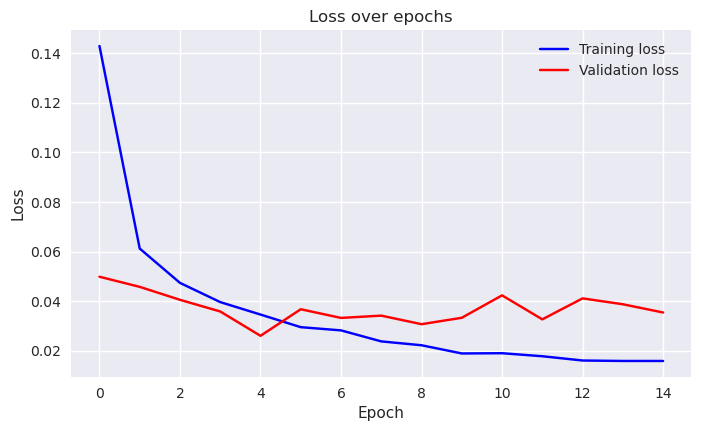

In [50]:
model_p2_3, optimizer, _ = p2_training_loop(model_p2_3, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

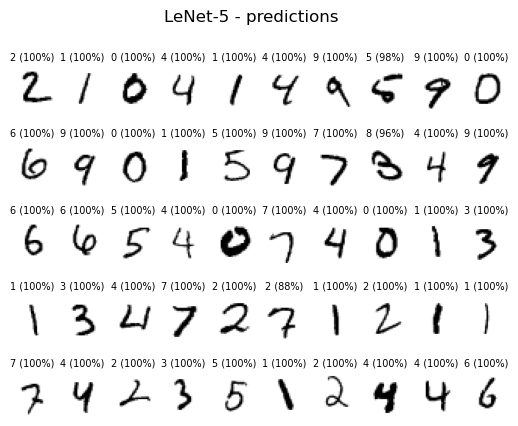

In [51]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.data[index], cmap='gray_r')
    
    with torch.no_grad():
        model_p2_3.eval()
        _, probs = model_p2_3(valid_dataset[index][0].unsqueeze(0).to(DEVICE))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - predictions');

In [52]:
for name, param in model_p2_3.named_parameters():
    # if param.requires_grad:
    if name == 'feature_extractor.0.weight':
        param_p2_3_bn1_w = param.data.to('cpu')
        print('Batch Norm 1 weight: ', param_p2_3_bn1_w.tolist())
    if name == 'feature_extractor.0.bias':
        param_p2_3_bn1_b = param.data.to('cpu')
        print('Batch Norm 1 bias: ', param_p2_3_bn1_b.tolist())
    if name == 'feature_extractor.3.weight':
        param_p2_3_bn2_w = param.data.to('cpu')
        print('Batch Norm 2 weight: ', param_p2_3_bn2_w.tolist())
    if name == 'feature_extractor.3.bias':
        param_p2_3_bn2_b = param.data.to('cpu')
        print('Batch Norm 2 bias: ', param_p2_3_bn2_b.tolist())
    if name == 'feature_extractor.7.weight':
        param_p2_3_bn3_w = param.data.to('cpu')
        print('Batch Norm 3 weight: ', param_p2_3_bn3_w.tolist())
    if name == 'feature_extractor.7.bias':
        param_p2_3_bn3_b = param.data.to('cpu')
        print('Batch Norm 3 bias: ', param_p2_3_bn3_b.tolist())
    if name == 'feature_extractor.11.weight':
        param_p2_3_bn4_w = param.data.to('cpu')
        print('Batch Norm 4 weight: ', param_p2_3_bn4_w.tolist())
    if name == 'feature_extractor.11.bias':
        param_p2_3_bn4_b = param.data.to('cpu')
        print('Batch Norm 4 bias: ', param_p2_3_bn4_b.tolist())
    if name == 'classifier.2.weight':
        param_p2_3_bn5_w = param.data.to('cpu')
        print('Batch Norm 5 weight: ', param_p2_3_bn5_w.tolist())
    if name == 'classifier.2.bias':
        param_p2_3_bn5_b = param.data.to('cpu')
        print('Batch Norm 5 bias: ', param_p2_3_bn5_b.tolist())
    # print(name, param.data)

Batch Norm 1 weight:  [1.2201811075210571]
Batch Norm 1 bias:  [0.7248329520225525]
Batch Norm 2 weight:  [0.973088800907135, 1.0940200090408325, 0.8970233798027039, 1.0467592477798462, 1.042639970779419, 1.3638643026351929]
Batch Norm 2 bias:  [0.32870402932167053, 0.2702917158603668, 0.032760702073574066, 0.29022979736328125, -0.28892895579338074, -0.01335316151380539]
Batch Norm 3 weight:  [0.9000139236450195, 0.8197963237762451, 1.298323392868042, 0.8283389806747437, 0.7524430155754089, 0.8520821928977966, 0.866289496421814, 0.8558027744293213, 0.9131988883018494, 1.0803883075714111, 0.8636021614074707, 1.0291575193405151, 0.9707651138305664, 1.19222891330719, 1.0996848344802856, 0.6647435426712036]
Batch Norm 3 bias:  [-0.047630779445171356, -0.03604980930685997, -0.08540438860654831, 0.13069458305835724, 0.08189312368631363, 0.056435056030750275, -0.07850584387779236, -0.01984434202313423, -0.02741907723248005, -0.028992418199777603, -0.08244757354259491, 0.009879078716039658, 0.

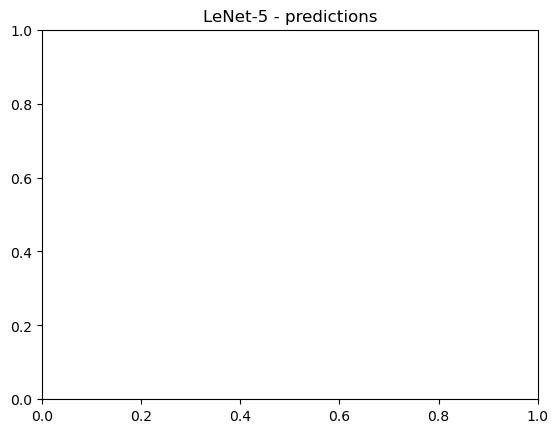

In [56]:
import matplotlib.pyplot as plt
import numpy as np

data_to_plot = [param_p2_3_bn1_w, param_p2_3_bn2_w, param_p2_3_bn3_w, param_p2_3_bn4_w, param_p2_3_bn5_w]
fig_p2_3 = plt.figure()
ax_p2_3 = fig.add_axes([0, -2, 1, 0.1])
bp_p2_3 = ax_p2_3.violinplot(data_to_plot)
plt.title('LeNet-5 - predictions');


4. Train the network without batch normalization but this time use dropout. For hidden layers use a
dropout probability of 0.5 and for input, layer take it to be 0.2 Compare test accuracy using dropout
to test accuracy obtained using batch normalization in parts 2 and 3. (4)

In [65]:
# define transforms
# transforms.ToTensor() automatically scales the images to [0,1] range
transforms_p2_4 = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transforms_p2_4,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transforms_p2_4)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

In [66]:
class LeNet5_p2_4(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5_p2_4, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Dropout(p=0.2),          
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.Dropout(p=0.5),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.Dropout(p=0.5),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.Dropout(p=0.5),
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=84, out_features=n_classes),
        )
        # self.fc1 = nn.Linear(in_features=120, out_features=84)
        # self.bn4 = nn.BatchNorm1d(84)
        # self.fc2 = nn.Linear(in_features=84, out_features=n_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        # x = self.fc1(x)
        # x = self.bn4(F.tanh(x))
        # logits = self.fc2(x)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [67]:
torch.manual_seed(RANDOM_SEED)

model_p2_4 = LeNet5_p2_4(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model_p2_4.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

summary(model_p2_4, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1            [-1, 1, 32, 32]               0
            Conv2d-2            [-1, 6, 28, 28]             156
              Tanh-3            [-1, 6, 28, 28]               0
           Dropout-4            [-1, 6, 28, 28]               0
         AvgPool2d-5            [-1, 6, 14, 14]               0
            Conv2d-6           [-1, 16, 10, 10]           2,416
              Tanh-7           [-1, 16, 10, 10]               0
           Dropout-8           [-1, 16, 10, 10]               0
         AvgPool2d-9             [-1, 16, 5, 5]               0
           Conv2d-10            [-1, 120, 1, 1]          48,120
             Tanh-11            [-1, 120, 1, 1]               0
          Dropout-12            [-1, 120, 1, 1]               0
           Linear-13                   [-1, 84]          10,164
             Tanh-14                   

13:47:09 --- Epoch: 0	Train loss: 0.4676	Valid loss: 0.1429	Train accuracy: 95.37	Valid accuracy: 95.63
13:47:38 --- Epoch: 1	Train loss: 0.2598	Valid loss: 0.1093	Train accuracy: 96.60	Valid accuracy: 96.76
13:48:05 --- Epoch: 2	Train loss: 0.2194	Valid loss: 0.0865	Train accuracy: 97.33	Valid accuracy: 97.48
13:48:33 --- Epoch: 3	Train loss: 0.2012	Valid loss: 0.0803	Train accuracy: 97.55	Valid accuracy: 97.62
13:49:00 --- Epoch: 4	Train loss: 0.1916	Valid loss: 0.0704	Train accuracy: 97.83	Valid accuracy: 97.78
13:49:28 --- Epoch: 5	Train loss: 0.1789	Valid loss: 0.0703	Train accuracy: 97.90	Valid accuracy: 97.96
13:49:54 --- Epoch: 6	Train loss: 0.1768	Valid loss: 0.0660	Train accuracy: 97.92	Valid accuracy: 98.13
13:50:20 --- Epoch: 7	Train loss: 0.1737	Valid loss: 0.0622	Train accuracy: 98.05	Valid accuracy: 98.09
13:50:46 --- Epoch: 8	Train loss: 0.1717	Valid loss: 0.0617	Train accuracy: 98.14	Valid accuracy: 98.13
13:51:13 --- Epoch: 9	Train loss: 0.1667	Valid loss: 0.0573	Trai

<ipython-input-36-a0bb8c0dfef0>:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


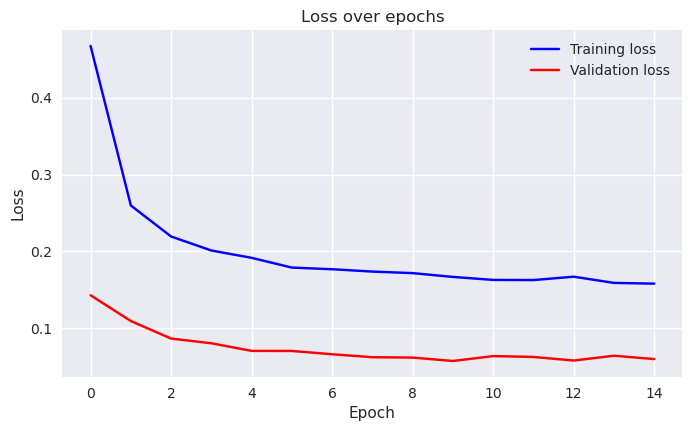

In [68]:
model_p2_4, optimizer, _ = p2_training_loop(model_p2_4, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

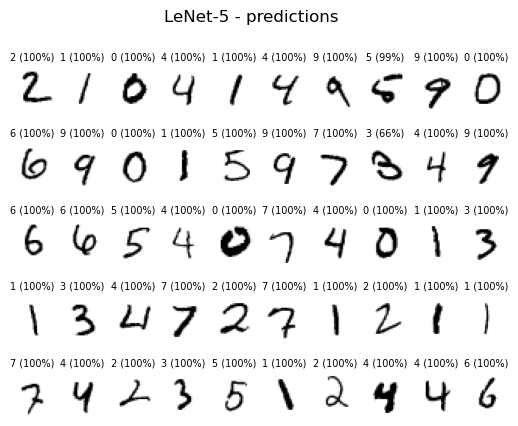

In [69]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.data[index], cmap='gray_r')
    
    with torch.no_grad():
        model_p2_4.eval()
        _, probs = model_p2_4(valid_dataset[index][0].unsqueeze(0).to(DEVICE))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - predictions');

5. Now train the network using both batch normalization and dropout. How does the performance (test
accuracy) of the network compare with the cases with dropout alone and with batch normalization
alone? (4)

In [70]:
# define transforms
# transforms.ToTensor() automatically scales the images to [0,1] range
transforms_p2_5 = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transforms_p2_5,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transforms_p2_5)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

In [76]:
class LeNet5_p2_5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5_p2_5, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.BatchNorm2d(1),  
            nn.Dropout(p=0.2),   
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.BatchNorm2d(6),
            nn.Dropout(p=0.5),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.BatchNorm2d(16),
            nn.Dropout(p=0.5),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.BatchNorm2d(120),
            nn.Dropout(p=0.5),
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.BatchNorm1d(84),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=84, out_features=n_classes),
        )
        # self.fc1 = nn.Linear(in_features=120, out_features=84)
        # self.bn4 = nn.BatchNorm1d(84)
        # self.fc2 = nn.Linear(in_features=84, out_features=n_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        # x = self.fc1(x)
        # x = self.bn4(F.tanh(x))
        # logits = self.fc2(x)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [77]:
torch.manual_seed(RANDOM_SEED)

model_p2_5 = LeNet5_p2_5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model_p2_5.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

summary(model_p2_5, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 1, 32, 32]               2
           Dropout-2            [-1, 1, 32, 32]               0
            Conv2d-3            [-1, 6, 28, 28]             156
              Tanh-4            [-1, 6, 28, 28]               0
       BatchNorm2d-5            [-1, 6, 28, 28]              12
           Dropout-6            [-1, 6, 28, 28]               0
         AvgPool2d-7            [-1, 6, 14, 14]               0
            Conv2d-8           [-1, 16, 10, 10]           2,416
              Tanh-9           [-1, 16, 10, 10]               0
      BatchNorm2d-10           [-1, 16, 10, 10]              32
          Dropout-11           [-1, 16, 10, 10]               0
        AvgPool2d-12             [-1, 16, 5, 5]               0
           Conv2d-13            [-1, 120, 1, 1]          48,120
             Tanh-14            [-1, 12

14:16:05 --- Epoch: 0	Train loss: 0.3945	Valid loss: 0.0823	Train accuracy: 97.23	Valid accuracy: 97.44
14:16:38 --- Epoch: 1	Train loss: 0.2093	Valid loss: 0.0766	Train accuracy: 97.46	Valid accuracy: 97.66
14:17:11 --- Epoch: 2	Train loss: 0.1893	Valid loss: 0.0658	Train accuracy: 97.89	Valid accuracy: 97.97
14:17:42 --- Epoch: 3	Train loss: 0.1726	Valid loss: 0.0601	Train accuracy: 98.06	Valid accuracy: 98.25
14:18:15 --- Epoch: 4	Train loss: 0.1661	Valid loss: 0.0537	Train accuracy: 98.34	Valid accuracy: 98.38
14:18:47 --- Epoch: 5	Train loss: 0.1570	Valid loss: 0.0522	Train accuracy: 98.43	Valid accuracy: 98.49
14:19:19 --- Epoch: 6	Train loss: 0.1551	Valid loss: 0.0558	Train accuracy: 98.46	Valid accuracy: 98.37
14:19:50 --- Epoch: 7	Train loss: 0.1502	Valid loss: 0.0565	Train accuracy: 98.40	Valid accuracy: 98.33
14:20:22 --- Epoch: 8	Train loss: 0.1462	Valid loss: 0.0502	Train accuracy: 98.61	Valid accuracy: 98.53
14:20:53 --- Epoch: 9	Train loss: 0.1452	Valid loss: 0.0510	Trai

<ipython-input-36-a0bb8c0dfef0>:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


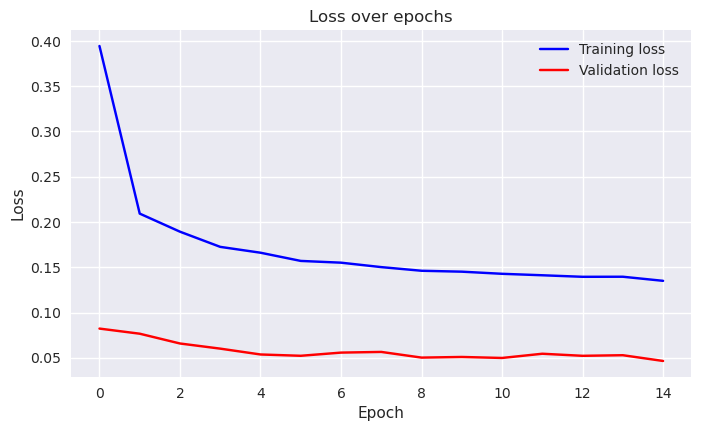

In [78]:
model_p2_5, optimizer, _ = p2_training_loop(model_p2_5, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

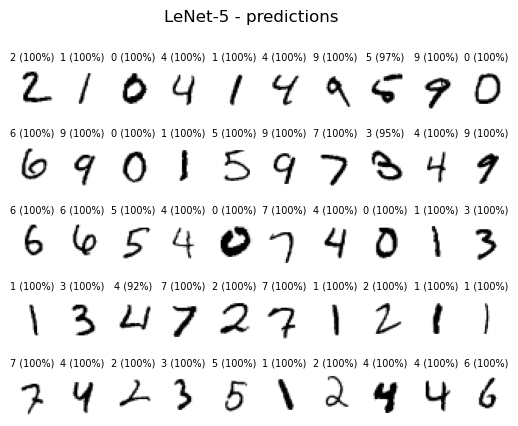

In [79]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.data[index], cmap='gray_r')
    
    with torch.no_grad():
        model_p2_5.eval()
        _, probs = model_p2_5(valid_dataset[index][0].unsqueeze(0).to(DEVICE))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - predictions');

LeNet-5 with both batch norm and dropout perform better than 4 and 3.

In [82]:
del model_p2_2
del model_p2_3
del model_p2_4
del model_p2_5

## Problem 3 - Learning Rate, Batch Size, FashionMNIST 15 points
Recall the cyclical learning rate policy discussed in the class. The learning rate changes in a cyclical manner between lrmin and lrmax, which are hyperparameters that need to be specified. For this problem, you first need to read carefully the article referenced below as you will be making use of the code there (in Keras) and modifying it as needed. For those who want to work in Pytorch, there are open source implementations of this policy available which you can easily search for and build over them. You will work with the FashionMNIST dataset and MiniGoogLeNet (described in reference).

1. Fix batch size to 64 and start with 10 candidate learning rates between 10−9 and 101 and train your
model for 5 epochs. Plot the training loss as a function of the learning rate. You should see a curve
like Figure 3 in the reference below. From that figure identify the values of lrmin and lrmax. (2)

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support

import torchvision
import torchvision.transforms as transforms

import time
import pandas as pd
import json
from IPython.display import clear_output

from operator import mod
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import math
import os

In [42]:
import math

BATCH_SIZE = 64
MINI_BATCH_SIZE = 64
batch_multiplier = BATCH_SIZE/MINI_BATCH_SIZE
lr_scale = math.sqrt(1/batch_multiplier)
lrs = [pow(10, x) * lr_scale for x in range(1, -9, -1)]

In [43]:
# define transforms
# transforms.ToTensor() automatically scales the images to [0,1] range
transforms_p3 = transforms.Compose([
    transforms.Resize(224),
    torchvision.transforms.Grayscale(num_output_channels=3),
    #transforms.Resize(256)，
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Use standard FashionMNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms_p3
)


valid_dataset = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms_p3
)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=MINI_BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=MINI_BATCH_SIZE, 
                          shuffle=False)

In [44]:
def train_p3(model, criterion, optimizer, batch_multiplier):
    # print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    # count = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # inputs = torch.cat((inputs, inputs, inputs), 1)
        inputs, targets = inputs.to(device), targets.to(device)
        # if count == 0:
        # print(targets.shape)
        optimizer.zero_grad()
        # count = batch_multiplier
        outputs = model(inputs)
        loss = criterion(outputs, targets) / batch_multiplier
        loss.backward()
        optimizer.step()
        # count -= 1
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # progress_bar(batch_idx, len(my_dataloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        #             % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        # for param in model.parameters():
        #     print(param)
    return train_loss

In [45]:
def test_p3(model, criterion, batch_multiplier):
    # global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valid_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets) / batch_multiplier

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # progress_bar(batch_idx, len(my_dataloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            #              % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    return test_loss

In [46]:
# model_p3 = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=False, init_weights=True)
# model_p3 = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
# model_p3.to(device)
# summary(model_p3, (3, 224, 224))

In [34]:
training_losses = []
for lr in lrs:
    
    model_p3 = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
    model_p3 = model_p3.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model_p3.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

    tr_loss = 0
    for epoch in range(0, 5):
        tr_loss = train_p3(model_p3, criterion, optimizer, batch_multiplier)
        test_p3(model_p3, criterion, batch_multiplier)
        scheduler.step()
    
    training_losses.append(tr_loss)

Using cache found in C:\Users\yz-li/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\yz-li/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\yz-li/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\yz-li/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\yz-li/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\yz-li/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\yz-li/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\yz-li/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\yz-li/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\yz-li/.cache\torch\hub\pytorch_vision_v0.10.0


In [37]:
# torch.save(model_p3.state_dict(), 'model_p3.pth')

In [47]:
def plot_losses_p3(train_losses, learningRates):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    # loss_data = np.transpose(np.vstack((np.array(train_losses), np.array(learningRates))))

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(learningRates, train_losses, color='blue', label='Training loss') 
    # ax.plot(learningRates, color='red', label='Validation loss')
    ax.set(title="Loss over learning rate", 
            xlabel='Learning Rate in log base of 10',
            ylabel='Training Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [48]:
print(training_losses)
print(lrs)
# training_losses.reverse()
# lrs.reverse()
plot_losses_p3([a for a in training_losses], [b for b in range(-8, 2, 1)])

NameError: name 'training_losses' is not defined

Note: I forget to divide the loss by length of dataset cause I am using different version of ancient training/testing code...AND I don't want to retrain the module for another 200 minutes...

2. Use the cyclical learning rate policy (with exponential decay) and train your network using batch size
64 and lrmin and lrmax values obtained in part 1. Plot train/validation loss and accuracy curve (similar
to Figure 4 in reference). (3)

In [49]:
model_p3 = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model_p3 = model_p3.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_p3.parameters(), lr=min(lrs))
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=min(lrs),  max_lr=max(lrs))

Using cache found in C:\Users\yz-li/.cache\torch\hub\pytorch_vision_v0.10.0


In [50]:
def train_p3_2(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [51]:
def validate_p3_2(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [56]:
def p3_training_loop(model, criterion, optimizer, scheduler, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):
        print('Epoch: ', epoch)
        # training
        model, optimizer, train_loss = train_p3_2(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)
        scheduler.step()
        # validation
        with torch.no_grad():
            model, valid_loss = validate_p3_2(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        # if epoch % print_every == (print_every - 1):
            
        #     train_acc = get_accuracy(model, train_loader, device=device)
        #     valid_acc = get_accuracy(model, valid_loader, device=device)
                
        #     print(f'{datetime.now().time().replace(microsecond=0)} --- '
        #           f'Epoch: {epoch}\t'
        #           f'Train loss: {train_loss:.4f}\t'
        #           f'Valid loss: {valid_loss:.4f}\t'
        #           f'Train accuracy: {100 * train_acc:.2f}\t'
        #           f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)


Epoch:  0


D:\anaconda3\lib\site-packages\torch\nn\functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4


<ipython-input-28-a0bb8c0dfef0>:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


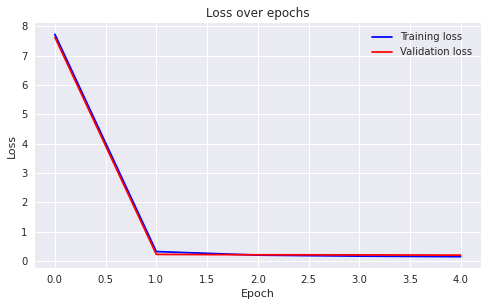

In [57]:
model_p3, optimizer, _ = p3_training_loop(model_p3, criterion, optimizer, scheduler, train_loader, valid_loader, 5, DEVICE)

3. We want to test if increasing batch size for a fixed learning rate has the same effect as decreasing learning rate for fixed batch size. Fix learning rate to lrmax and train your network starting with batch size 32 and incrementally going up to 16384 (in increments of a factor of 2; like 32, 64...). You can choose a step size (in terms of the number of iterations) to increment the batch size. If your GPU cannot handle large batch sizes, you need to employ an effective batch size approach as discussed in Lecture 3 to simulate large batches. Plot the training loss. Is the generalization of your final model similar or different from than cyclical learning rate policy? (10)

In [58]:
import math

batch_sizes = [32 * pow(2, x) for x in range(0, 10)]
MINI_BATCH_SIZE = 32

# batch_multipliers = BATCH_SIZE/MINI_BATCH_SIZE
lr_scale = math.sqrt(1/batch_multiplier)


In [59]:
# define transforms
# transforms.ToTensor() automatically scales the images to [0,1] range
transforms_p3 = transforms.Compose([
    transforms.Resize(224),
    torchvision.transforms.Grayscale(num_output_channels=3),
    #transforms.Resize(256)，
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Use standard FashionMNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms_p3
)


valid_dataset = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms_p3
)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=MINI_BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=MINI_BATCH_SIZE, 
                          shuffle=False)

In [60]:
def train_p3_3(train_loader, model, criterion, optimizer, batch_multiplier):
    # print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    count = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # inputs = torch.cat((inputs, inputs, inputs), 1)
        inputs, targets = inputs.to(device), targets.to(device)
        if count == 0:
        # print(targets.shape)
            optimizer.step()
            optimizer.zero_grad()
            count = batch_multiplier
        outputs = model(inputs)
        loss = criterion(outputs, targets) / batch_multiplier
        loss.backward()
       
        count -= 1
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # progress_bar(batch_idx, len(my_dataloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        #             % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        # for param in model.parameters():
        #     print(param)
    return train_loss / len(train_loader.dataset)

In [61]:
def validate_p3_3(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return epoch_loss

In [62]:
def p3_training_loop(model, train_loader, valid_loader, device, batch_sizes, lr):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(len(batch_sizes)):
        batch_size = batch_sizes[epoch]
        batch_multiplier = batch_size/MINI_BATCH_SIZE
        lr_scale = math.sqrt(1/batch_multiplier)
        
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model_p3.parameters(), lr=lr*lr_scale)
        # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)   

        # training
        train_loss = train_p3_3(train_loader, model, criterion, optimizer, batch_multiplier)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            valid_loss = validate_p3_3(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

    plot_losses(train_losses, valid_losses)
    # return model, optimizer, (train_losses, valid_losses)

Using cache found in C:\Users\yz-li/.cache\torch\hub\pytorch_vision_v0.10.0
D:\anaconda3\lib\site-packages\torch\nn\functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
<ipython-input-28-a0bb8c0dfef0>:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


TypeError: cannot unpack non-iterable NoneType object

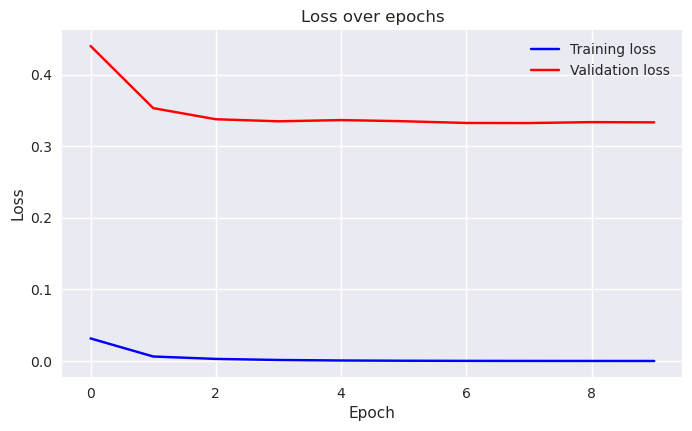

In [63]:
model_p3 = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model_p3 = model_p3.to(device)

p3_training_loop(model_p3, train_loader, valid_loader, DEVICE, batch_sizes, 0.001)

## Problem 4 - Adaptive Learning Rate Methods, CIFAR-10 20 points

We will consider five methods, AdaGrad, RMSProp, RMSProp+Nesterov, AdaDelta, Adam, and study their
convergence using the CIFAR-10 dataset. We will use a multi-layer neural network model with two fully
connected hidden layers with 1000 hidden units each and ReLU activation with a minibatch size of 128.

In [69]:
class P4(nn.Module):
    def __init__(self):
        super(P4, self).__init__()
        self.inputlayer = Linear_BasicBlock(1024, 1000)
        self.outputlayer = Linear_BasicBlock(1000, 10)
    
    def forward(self, x):
        out = self.inputlayer(x)
        out = self.outputlayer(out)
        return out

In [70]:
model_p4 = P4()
model_p4 = model_p4.to(device)

In [71]:
LEARNING_RATE = 0.01
MINI_BATCH_SIZE = 128
MOMENTUM = 0
WEIGHT_DECAY = 1e-5
LR_DECAY = 0

1. Write the weight update equations for the five adaptive learning rate methods. Explain each term
clearly. What are the hyperparameters in each policy? Explain how AdaDelta and Adam are different
from RMSProp. (5+1)

In [72]:
optim_adagrad = torch.optim.Adagrad(model_p4.parameters(), lr=LEARNING_RATE, lr_decay=LR_DECAY, weight_decay=WEIGHT_DECAY)

In [73]:
optim_rmsprop = torch.optim.RMSprop(model_p4.parameters(), lr=LEARNING_RATE)

In [74]:
optim_rmsprop_nesterov = torch.optim.RMSprop(model_p4.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)

In [75]:
optim_adadelta = torch.optim.Adadelta(model_p4.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [76]:
optim_adam = torch.optim.Adam(model_p4.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

2. Train the neural network using all the five methods with L2-regularization for 200 epochs each and plot
the training loss vs the number of epochs. Which method performs best (lowest training loss)? (5)

In [77]:
# define transforms
# transforms.ToTensor() automatically scales the images to [0,1] range
transforms_p4 = transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=1),
    transforms.Resize(32),
    # transforms.Resize(224),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x))
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Use standard FashionMNIST dataset
train_dataset = torchvision.datasets.CIFAR10(
    root = './data/CIFAR10',
    train = True,
    download = True,
    transform = transforms_p4
)


valid_dataset = torchvision.datasets.CIFAR10(
    root = './data/CIFAR10',
    train = False,
    download = True,
    transform = transforms_p4
)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=MINI_BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=MINI_BATCH_SIZE, 
                          shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [85]:
def plot_single_losses(train_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [86]:
def p4_training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):
        print('Epoch: ', epoch)
        # training
        model, optimizer, train_loss = train_p3_2(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)
        # scheduler.step()
        # validation
        with torch.no_grad():
            model, valid_loss = validate_p3_2(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

    # plot_losses(train_losses, valid_losses)
    plot_single_losses(train_losses)
    return model, optimizer, (train_losses, valid_losses)


Optimizer Index:  0
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49
Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:  55
Epoch:  56
Epoch:  57
Epoch:  58
Epoch:  59
Epoch:  60
Epoch:  61
Epoch:  62
Epoch:  63
Epoch:  64
Epoch:  65
Epoch:  66
Epoch:  67
Epoch:  68
Epoch:  69
Epoch:  70
Epoch:  71
Epoch:  72
Epoch:  73
Epoch:  74
Epoch:  75
Epoch:  76
Epoch:  77
Epoch:  78
Epoch:  79
Epoch:  80
Epoch:  81
Epoch:  82
Epoch:  83
Epoch:  84
Epoch:  85
Epoch:  86
Epoch:  87
Epoch:  88
Epoch:  89


<ipython-input-28-a0bb8c0dfef0>:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Optimizer Index:  1
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49
Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:  55
Epoch:  56
Epoch:  57
Epoch:  58
Epoch:  59
Epoch:  60
Epoch:  61
Epoch:  62
Epoch:  63
Epoch:  64
Epoch:  65
Epoch:  66
Epoch:  67
Epoch:  68
Epoch:  69
Epoch:  70
Epoch:  71
Epoch:  72
Epoch:  73
Epoch:  74
Epoch:  75
Epoch:  76
Epoch:  77
Epoch:  78
Epoch:  79
Epoch:  80
Epoch:  81
Epoch:  82
Epoch:  83
Epoch:  84
Epoch:  85
Epoch:  86
Epoch:  87
Epoch:  88
Epoch:  89


<ipython-input-28-a0bb8c0dfef0>:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Optimizer Index:  2
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49
Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:  55
Epoch:  56
Epoch:  57
Epoch:  58
Epoch:  59
Epoch:  60
Epoch:  61
Epoch:  62
Epoch:  63
Epoch:  64
Epoch:  65
Epoch:  66
Epoch:  67
Epoch:  68
Epoch:  69
Epoch:  70
Epoch:  71
Epoch:  72
Epoch:  73
Epoch:  74
Epoch:  75
Epoch:  76
Epoch:  77
Epoch:  78
Epoch:  79
Epoch:  80
Epoch:  81
Epoch:  82
Epoch:  83
Epoch:  84
Epoch:  85
Epoch:  86
Epoch:  87
Epoch:  88
Epoch:  89


<ipython-input-28-a0bb8c0dfef0>:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Optimizer Index:  3
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49
Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:  55
Epoch:  56
Epoch:  57
Epoch:  58
Epoch:  59
Epoch:  60
Epoch:  61
Epoch:  62
Epoch:  63
Epoch:  64
Epoch:  65
Epoch:  66
Epoch:  67
Epoch:  68
Epoch:  69
Epoch:  70
Epoch:  71
Epoch:  72
Epoch:  73
Epoch:  74
Epoch:  75
Epoch:  76
Epoch:  77
Epoch:  78
Epoch:  79
Epoch:  80
Epoch:  81
Epoch:  82
Epoch:  83
Epoch:  84
Epoch:  85
Epoch:  86
Epoch:  87
Epoch:  88
Epoch:  89


<ipython-input-28-a0bb8c0dfef0>:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Optimizer Index:  4
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49
Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:  55
Epoch:  56
Epoch:  57
Epoch:  58
Epoch:  59
Epoch:  60
Epoch:  61
Epoch:  62
Epoch:  63
Epoch:  64
Epoch:  65
Epoch:  66
Epoch:  67
Epoch:  68
Epoch:  69
Epoch:  70
Epoch:  71
Epoch:  72
Epoch:  73
Epoch:  74
Epoch:  75
Epoch:  76
Epoch:  77
Epoch:  78
Epoch:  79
Epoch:  80
Epoch:  81
Epoch:  82
Epoch:  83
Epoch:  84
Epoch:  85
Epoch:  86
Epoch:  87
Epoch:  88
Epoch:  89


<ipython-input-28-a0bb8c0dfef0>:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


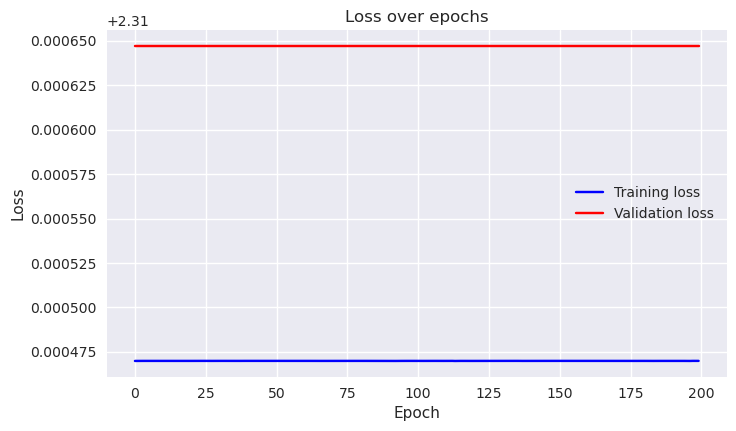

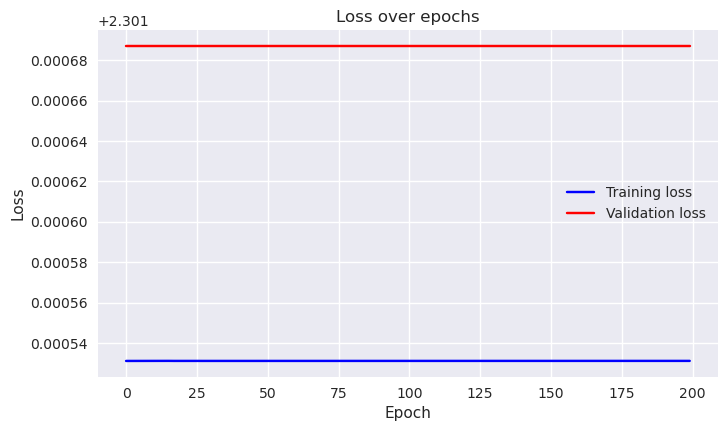

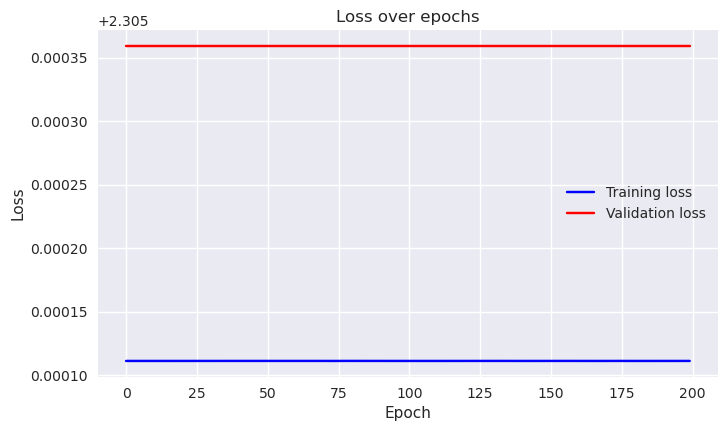

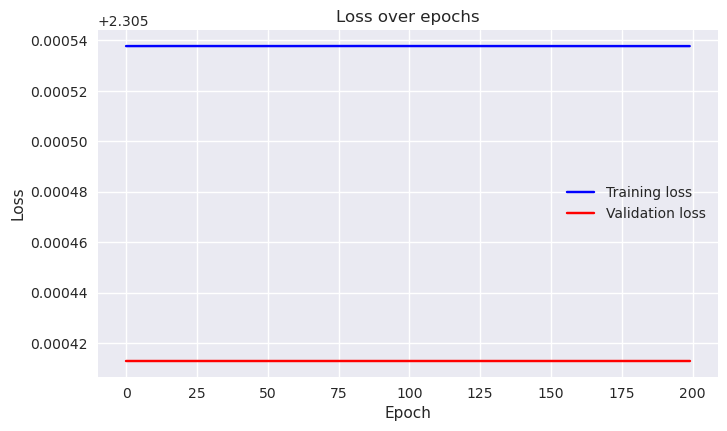

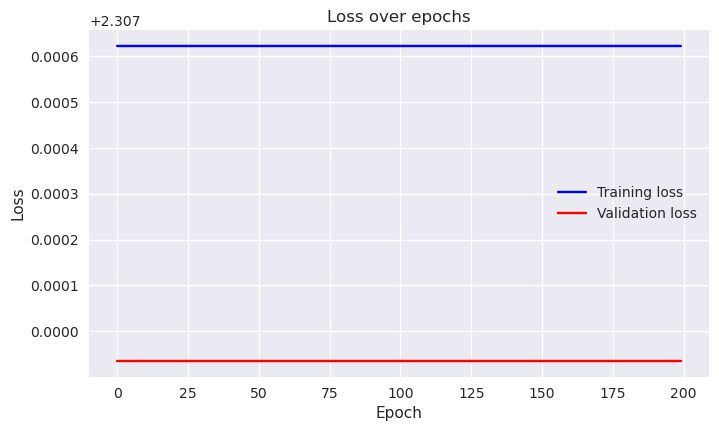

In [84]:
optimizers = [optim_adagrad, optim_rmsprop, optim_rmsprop_nesterov, optim_adadelta, optim_adam]
criterion = torch.nn.CrossEntropyLoss()
for index, optimizer in enumerate(optimizers):
    print('Optimizer Index: ', index)
    model_p4 = P4()
    model_p4 = model_p4.to(device)
    p4_training_loop(model_p4, criterion, optimizer, train_loader, valid_loader, 200, DEVICE)

3. Add dropout (probability 0.2 for input layer and 0.5 for hidden layers) and train the neural network
again using all the five methods for 200 epochs. Compare the training loss with that in part 2. Which
method performs the best? For the five methods, compare their training time (to finish 200 epochs
with dropout) to the training time in part 2 (to finish 200 epochs without dropout). (5)

In [89]:
class P4_3(nn.Module):
    def __init__(self):
        super(P4_3, self).__init__()
        self.dropout1 = nn.Dropout(0.2)
        self.linear1 = Linear_BasicBlock(1024, 1000)
        self.dropout2 = nn.Dropout(0.5)
        self.linear2 = Linear_BasicBlock(1000, 10)
    
    def forward(self, x):
        out = self.dropout1(x)
        out = self.linear1(out)
        out = self.dropout2(out)
        out = self.linear2(out)
        return out

Optimizer Index:  0
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49
Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:  55
Epoch:  56
Epoch:  57
Epoch:  58
Epoch:  59
Epoch:  60
Epoch:  61
Epoch:  62
Epoch:  63
Epoch:  64
Epoch:  65
Epoch:  66
Epoch:  67
Epoch:  68
Epoch:  69
Epoch:  70
Epoch:  71
Epoch:  72
Epoch:  73
Epoch:  74
Epoch:  75
Epoch:  76
Epoch:  77
Epoch:  78
Epoch:  79
Epoch:  80
Epoch:  81
Epoch:  82
Epoch:  83
Epoch:  84
Epoch:  85
Epoch:  86
Epoch:  87
Epoch:  88
Epoch:  89


<ipython-input-85-aba799550717>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Optimizer Index:  1
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49
Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:  55
Epoch:  56
Epoch:  57
Epoch:  58
Epoch:  59
Epoch:  60
Epoch:  61
Epoch:  62
Epoch:  63
Epoch:  64
Epoch:  65
Epoch:  66
Epoch:  67
Epoch:  68
Epoch:  69
Epoch:  70
Epoch:  71
Epoch:  72
Epoch:  73
Epoch:  74
Epoch:  75
Epoch:  76
Epoch:  77
Epoch:  78
Epoch:  79
Epoch:  80
Epoch:  81
Epoch:  82
Epoch:  83
Epoch:  84
Epoch:  85
Epoch:  86
Epoch:  87
Epoch:  88
Epoch:  89


<ipython-input-85-aba799550717>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Optimizer Index:  2
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49
Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:  55
Epoch:  56
Epoch:  57
Epoch:  58
Epoch:  59
Epoch:  60
Epoch:  61
Epoch:  62
Epoch:  63
Epoch:  64
Epoch:  65
Epoch:  66
Epoch:  67
Epoch:  68
Epoch:  69
Epoch:  70
Epoch:  71
Epoch:  72
Epoch:  73
Epoch:  74
Epoch:  75
Epoch:  76
Epoch:  77
Epoch:  78
Epoch:  79
Epoch:  80
Epoch:  81
Epoch:  82
Epoch:  83
Epoch:  84
Epoch:  85
Epoch:  86
Epoch:  87
Epoch:  88
Epoch:  89


<ipython-input-85-aba799550717>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Optimizer Index:  3
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49
Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:  55
Epoch:  56
Epoch:  57
Epoch:  58
Epoch:  59
Epoch:  60
Epoch:  61
Epoch:  62
Epoch:  63
Epoch:  64
Epoch:  65
Epoch:  66
Epoch:  67
Epoch:  68
Epoch:  69
Epoch:  70
Epoch:  71
Epoch:  72
Epoch:  73
Epoch:  74
Epoch:  75
Epoch:  76
Epoch:  77
Epoch:  78
Epoch:  79
Epoch:  80
Epoch:  81
Epoch:  82
Epoch:  83
Epoch:  84
Epoch:  85
Epoch:  86
Epoch:  87
Epoch:  88
Epoch:  89


<ipython-input-85-aba799550717>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49
Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:  55
Epoch:  56
Epoch:  57
Epoch:  58
Epoch:  59
Epoch:  60
Epoch:  61
Epoch:  62
Epoch:  63
Epoch:  64
Epoch:  65
Epoch:  66
Epoch:  67
Epoch:  68
Epoch:  69
Epoch:  70
Epoch:  71
Epoch:  72
Epoch:  73
Epoch:  74
Epoch:  75
Epoch:  76
Epoch:  77
Epoch:  78
Epoch:  79
Epoch:  80
Epoch:  81
Epoch:  82
Epoch:  83
Epoch:  84
Epoch:  85
Epoch:  86
Epoch:  87
Epoch:  88
Epoch:  89
Epoch:  90
Epoch:  91
Epoch:  

<ipython-input-85-aba799550717>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


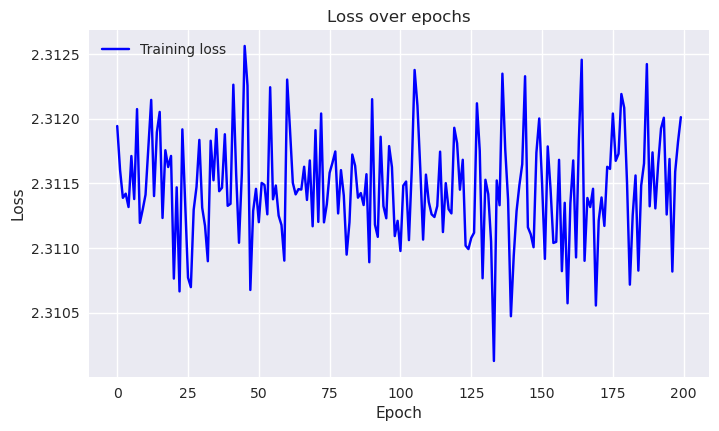

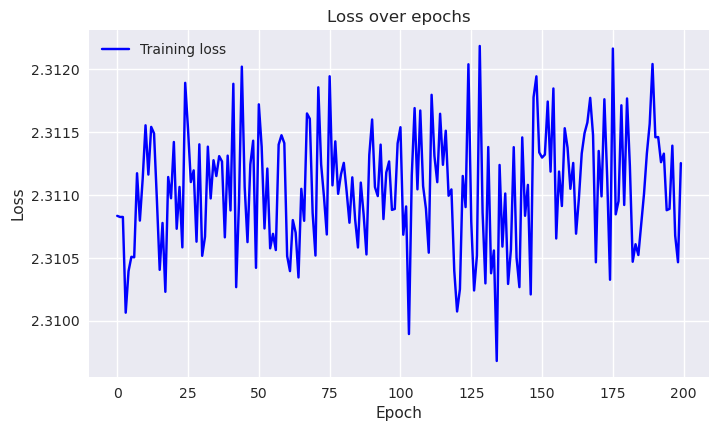

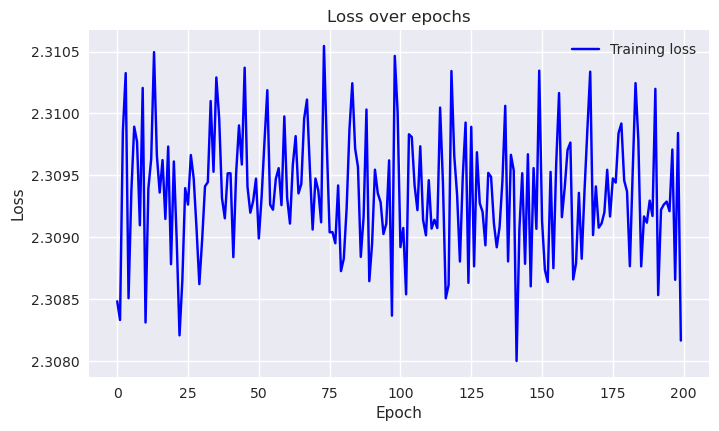

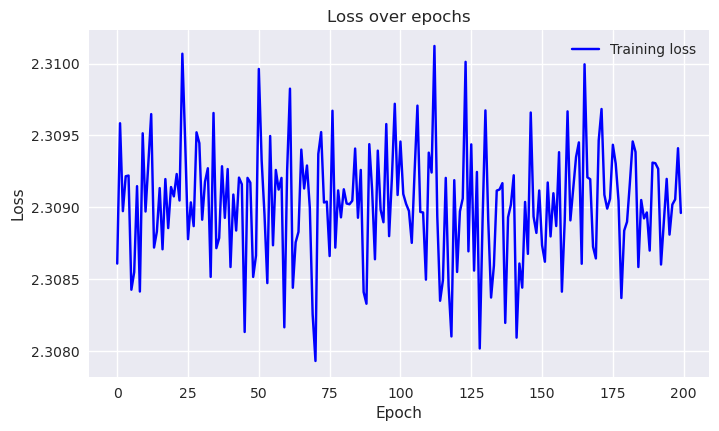

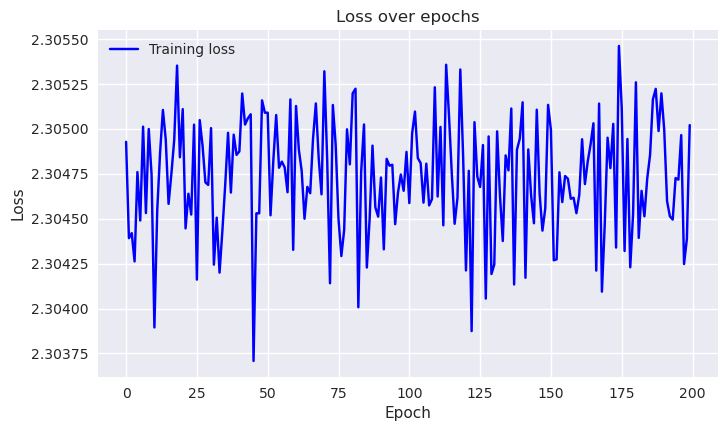

In [91]:
optimizers = [optim_adagrad, optim_rmsprop, optim_rmsprop_nesterov, optim_adadelta, optim_adam]
criterion = torch.nn.CrossEntropyLoss()
for index, optimizer in enumerate(optimizers):
    print('Optimizer Index: ', index)
    model_p4 = P4_3()
    model_p4 = model_p4.to(device)
    p4_training_loop(model_p4, criterion, optimizer, train_loader, valid_loader, 200, DEVICE)

4. Compare test accuracy of the trained model for all the five methods from part 2 and part 3. Note
that to calculate test accuracy of the model trained using dropout you need to appropriately scale the
weights (by the dropout probability). (4)

# Problem 5 - Convolutional Neural Networks Architectures 25 points

In this problem, we will study and compare different convolutional neural network architectures. We will
calculate the number of parameters (weights, to be learned) and the memory requirement of each network.
We will also analyze inception modules and understand their design.

1. Calculate the number of parameters in Alexnet. You will have to show calculations for each layer and
then sum it to obtain the total number of parameters in Alexnet. When calculating you will need to
account for all the filters (size, strides, padding) at each layer. Look at Sec. 3.5 and Figure 2 in Alexnet paper (see reference). Points will only be given when explicit calculations are shown for each layer. (4)

| Layer ID | Type | Number of Params | Output Shape |
|---|---|---|---|
| Conv2d-1 | Conv 11 * 11 Stride of 4 | ((11 * 11 * 3) + 1) * 64 = 23296 | 55 * 55 * 64 |
| ReLu-2 | Relu | 0 | 55 * 55 * 64 |
| MaxPool2d-3 | Max Pooling 3 * 3 Stride 2 | 0 | 27 * 27 * 64 |
| Conv2d-4 | Conv 5 * 5 Stride 1 Padding 2 | ((5 * 5 * 64) + 1) * 192 = 307392 | 27 * 27 * 96 * 2 |
| ReLu-5 | Relu | 0 | 55 * 55 * 64 |
| MaxPool2d-6 | Max Pooling 3 * 3 Stride 2 | 0 | 13 * 13 * 192 |
| Conv2d-7 | Conv 3 * 3 Stride 1 Padding 1 | ((3 * 3 * 192) + 1) * 384 = 663936 | 13 * 13 * 192 * 2 |
| ReLu-8 | Relu | 0 | 13 * 13 * 384 |
| Conv2d-9 | Conv 3 * 3 Stride 1 Padding 1 | ((3 * 3 * 384) + 1) * 256 = 884922 | 13 * 13 * 128 * 2 |
| ReLu-10 | Relu | 0 | 13 * 13 * 128 * 2 |
| Conv2d-11 | Conv 3 * 3 Stride 1 Padding 1 | ((3 * 3 * 256) + 1) * 256 = 590080 | 13 * 13 * 128 * 2 |
| ReLu-12 | Relu | 0 | 13 * 13 * 128 * 2 |
| MaxPool2d-13 | Max Pooling 3 * 3 Stride 2 | 0 | 6 * 6 * 128 * 2 |
| AvgPool2d-14 | Average Pooling 3 * 3 Stride 2 | 0 | 6 * 6 * 128 * 2 |
| Dropout-15 | Dropout | 0 | 4096 * 2 |
| Linear-16 | Fully-connected | (9216 + 1) * 4096 = 37752832 | 2048 * 2 |
| ReLu-17 | Relu | 0 | 2048 * 2 |
| Dropout-18 | Dropout | 0 | 2048 * 2 |
| Linear-19 | Fully-connected | (4096 + 1) * 4096 = 16781312 | 2048 * 2 |
| ReLu-20 | Relu | 0 | 2048 * 2 |
| Linear-21 | Fully-connected | (2048 + 1) * 1000 = 4097000 | 1000 |

Total trainable parameters: 61,100,770

In [1]:
import torch
from torchsummary import summary
model_alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model_alexnet = model_alexnet.to('cuda')
summary(model_alexnet, (3, 224, 224))

Using cache found in C:\Users\yz-li/.cache\torch\hub\pytorch_vision_v0.10.0


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

2. VGG (Simonyan et al.) has an extremely homogeneous architecture that only performs 3x3 convolutions
with stride 1 and pad 1 and 2x2 max pooling with stride 2 (and no padding) from the beginning to
the end. However VGGNet is very expensive to evaluate and uses a lot more memory and parameters.
Refer to VGG19 architecture on page 3 in Table 1 of the paper by Simonyan et al. You need to complete
Table 1 below for calculating activation units and parameters at each layer in VGG19 (without counting
biases). Its been partially filled for you. (6)

In [8]:
model_alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
model_alexnet = model_alexnet.to('cuda')
summary(model_alexnet, (3, 224, 224))

Using cache found in C:\Users\yz-li/.cache\torch\hub\pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\yz-li/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:16<00:00, 34.6MB/s] 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

| Layer     | Calculation       | Number of Activations (Memory) | Calculation             | Parameters (w/o bias) |
| --------- | ----------------- | ------------------------------ | ----------------------- | --------------------- |
| Input     |  224\*224\*3      | 150528                         | 0                       | 0                     |
| CONV3-64  |  224\*224\*64     | 3211264                        |  (3 \* 3 \* 3) \* 64    | 1728                  |
| CONV3-64  |  224\*224\*64     | 3211264                        |  (3 \* 3 \* 64) \* 64   | 36864                 |
| POOL2     | 112\*112\*64      | 802816                         | 0                       | 0                     |
| CONV3-128 | 112 \* 112 \* 128 | 1605632                        |  (3 \* 3 \* 64) \* 128  | 73728                 |
| CONV3-128 | 112 \* 112 \* 128 | 1605632                        |  (3 \* 3 \* 128) \* 128 | 147456                |
| POOL2     | 56 \* 56 \* 128   | 401408                         | 0                       | 0                     |
| CONV3-256 | 56 \* 56 \*256    | 802816                         | (3 \* 3 \* 128) \* 256  | 294912                |
| CONV3-256 | 56 \* 56 \*256    | 802816                         | (3 \* 3 \* 256) \* 256  | 589824                |
| CONV3-256 | 56 \* 56 \*256    | 802816                         | (3 \* 3 \* 256) \* 256  | 589824                |
| CONV3-256 | 56 \* 56 \*256    | 802816                         | (3 \* 3 \* 256) \* 256  | 589824                |
| POOL2     | 28 \* 28 \* 512   | 401408                         | 0                       | 0                     |
| CONV3-512 | 28\*28\*512       | 401408                         | (3\*3\*256)\*512        | 1179648               |
| CONV3-512 | 28\*28\*512       | 401408                         | (3 \* 3 \* 512) \* 512  | 2359296               |
| CONV3-512 | 28\*28\*512       | 401408                         | (3 \* 3 \* 512) \* 512  | 2359296               |
| CONV3-512 | 28\*28\*512       | 401408                         | (3 \* 3 \* 512) \* 512  | 2359296               |
| POOL2     | 14\*14\*512       | 100352                         | 0                       | 0                     |
| CONV3-512 | 14\*14\*512       | 100352                         | (3 \* 3 \* 512) \* 512  | 2359296               |
| CONV3-512 | 14\*14\*512       | 100352                         | (3 \* 3 \* 512) \* 512  | 2359296               |
| CONV3-512 | 14\*14\*512       | 100352                         | (3 \* 3 \* 512) \* 512  | 2359296               |
| CONV3-512 | 14\*14\*512       | 100352                         | (3 \* 3 \* 512) \* 512  | 2359296               |
| POOL2     | 7\*7\*512         | 25088                          | 0                       | 0                     |
| FC        | 4096              | 4096                           | (7\*7\*512)\*4096       | 102760448             |
| FC        | 4096              | 4096                           | 4096 \* 4096            | 16777216              |
| FC        | 1000              | 1000                           | 4096 \* 1000            | 4096000               |
| TOTAL     | N/A               | 16742888                       | N/A                     | 143652544             |

3. VGG architectures have smaller filters but deeper networks compared to Alexnet (3x3 compared to
11x11 or 5x5). Show that a stack of N convolution layers each of filter size F × F has the same
receptive field as one convolution layer with filter of size (NF − N + 1) × (NF − N + 1). Use this to
calculate the receptive field of 3 filters of size 5x5. (3)

Suppose the last layer is w*w. So the second last layer is (W + (F-1)) *  (W + (F-1)) and so on so forth so we can prove the receptivie field at the first layer is (W + N(F - 1)) * (W + N(F - 1)) which is equivalent to one convolution layer with filter size (NF - N + 1) * (NF - N + 1). for 3 5*5 filters, the reciptive field is (W + 13) * (W + 13)

4. The original Googlenet paper (Szegedy et al.) proposes two architectures for Inception module, shown
in Figure 2 on page 5 of the paper, referred to as naive and dimensionality reduction respectively.

(a) What is the general idea behind designing an inception module (parallel convolutional filters of
different sizes with a pooling followed by concatenation) in a convolutional neural network ? (2)

In general, the inception module is designed to that the network can learn better. However, previous approach has intense computation complexity so the inception module is used to reduce computation and number of parameters while keep relatively large receptive field so the neuron won't rely on several previous neuron heavily.

(b) Assuming the input to inception module (referred to as ”previous layer” in Figure 2 of the paper)
has size 32x32x256, calculate the output size after filter concatenation for the naive and
dimensionality reduction inception architectures with number of filters given in Figure 1. (3)

- Naive version:
  - Conv 1\*1\*128 => 32\*32\*128
  - Conv 3\*3\*192 => 30\*30\*192
  - Conv 5\*5\*96 => 28\*28\*96
  - MaxPool 3\*3 => 11\*11\*256
  - Concat: 32\*32\*672
- Dimension Reduction:
  - Conv 1\*1\*128 => 1\*1\*128
  - Conv 1\*1\*128 + 3\*3\*192 => 30\*30\*192
  - Conv 1\*1\*32 + 5\*5\*96 => 28\*28\*96
  - MaxPool 3\*3 + 1\*1\*64 => 11\*11\*64
  - Concat: 30\*30\*480

(c) Next calculate the total number of convolutional operations for each of the two inception architecture
again assuming the input to the module has dimensions 32x32x256 and number of filters
given in Figure 1. (3)

| Layer         | Output size | Calculation            | Result    | Layer     | Output size | Calculation            | Result         | Total     |
| ------------- | ----------- | ---------------------- | --------- | --------- | ----------- | ---------------------- | -------------- | --------- |
| 1\*1\*128     | 32\*32\*128 | 32\*32\*256\*128       | 33554432  |           |             |                        |                | 33554432  |
| 3\*3\*192     | 30\*30\*192 | 30\*30\*3\*3\*256\*192 | 398131200 |           |             |                        |                | 398131200 |
| 5\*5\*96      | 28\*28\*96  | 28\*28\*5\*5\*256\*96  | 481689600 |           |             |                        |                | 481689600 |
|               |             |                        |           |           |             |                        | Naïve Version: | 913375232 |
|               |             |                        |           |           |             |                        |                |           |
|               |             |                        |           |           |             |                        |                |           |
| 1\*1\*128     | 32\*32\*128 | 32\*32\*256\*128       | 33554432  |           |             |                        |                | 33554432  |
| 1\*1\*128     | 32\*32\*128 | 32\*32\*256\*128       | 33554432  | 3\*3\*192 | 30\*30\*128 | 3\*3\*30\*30\*192\*128 | 199065600      | 232620032 |
| 1\*1\*32      | 32\*32\*32  | 32\*32\*32\*256        | 8388608   | 5\*5\*96  | 28\*28\*96  | 5\*5\*28\*28\*96\*32   | 60211200       | 68599808  |
| 3\*3 max pool | 11\*11\*256 | 0                      | 0         | 1\*1\*64  | 11\*11\*64  | 11\*11\*1\*1\*64\*256  | 1982464        | 1982464   |
|               |             |                        |           |           |             |                        | Dim Reductions | 336756736 |

(d) Based on the calculations in part (c) explain the problem with naive architecture and how dimensionality
reduction architecture helps (Hint: compare computational complexity). How much is the
computational saving ? (2+2)

Save: 36.87% computation. The reduction approach use a smaller convlution kernel first to reduce the number of feature maps or dimension of the tensor to save the computation. 

However, according to my knowledge in 6913/9413/6213 and research, mearly compare the number of multiplcations and addition is meaning less to compare the speedup and effectiveness due to hardware acceleration approaches and dependency issue which is the bottleneck of parallel computing.